In [1]:
import numpy as np
import pandas as pd
from scipy.io import *
from pylab import *
from pandas import DataFrame as df
import scipy
from PIL import Image
# import random
from scipy import stats
from pyclustering.cluster.kmeans import kmeans
from pyclustering.utils.metric import type_metric, distance_metric
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from scipy.spatial import distance

In [2]:
FPPs = loadmat('Matrix120.mat')['s'][0]
communitiest = loadmat('Cluster120.mat')['b'][0]


In [3]:
# for i in range(len(FPP)):
#     FPP_= FPP[i].reshape(len(FPP[i]), 51, 20)
#     for j in range(len(FPP_)):
#         title('Rat %i FPP %i'%(i+1,j+1 ))
#         imshow(FPP_[j],extent=[-np.pi, np.pi, 20, 120],aspect='auto' )
#         ylabel('Frequencies(Hz)')
#         xlabel('Phase')
#         colorbar()
# #         savefig('Rat%i_FPP_%i'%(i+1, j+1))
#         show()

In [56]:
def pearson_dist(x, y):
    r = stats.pearsonr(x, y)[0]
    return (1 - r) / 2

def kmeans_(FPP, k=3):
    # define a custom metric
    metric = distance_metric(type_metric.USER_DEFINED, func=pearson_dist)
    # carry out a km++ init
    initial_centers = kmeans_plusplus_initializer(FPP, k).initialize()
    # execute kmeans
    kmeans_instance = kmeans(FPP, initial_centers, metric=metric)
    # run cluster analysis
    kmeans_instance.process()
    # get clusts
    clusters = kmeans_instance.get_clusters()

    return clusters
                    

In [5]:
#  Get amount of clusters expected through community clustering
maxima=[]
for i in range(1,16, 2):
    maxima.append(np.mean(communitiest[i]))
PFC_k= round(np.mean(np.array(maxima)))
maxima2=[]
for i in range(0,16,2):
    maxima2.append(np.mean(communitiest[i]))
HPC_k=round(np.mean(np.array(maxima2)))


In [6]:
# Retrieve HMM clustering labels

pfc_clusters=[]
for i in range(1,16,2):
    rat = FPPs[i]
    c =PFC_k
    pfc_clusters.append(kmeans_(rat, k=c))
hpc_clusters=[]
for i in range(0,16,2):
    rat = FPPs[i]
    c =HPC_k
    hpc_clusters.append(kmeans_(rat, k=c))


In [7]:
def recluster(FPP, clusters, start=0, step=2):
    '''
    Input: all FPPs, cluster labels from kmeans, start and step point rat iteration
    Export: all clusters for all rats
    Retrieve the data within the clusters
    '''
    pls = []
    for i in range(start,16,step):
        cl_ = []
        for j in range(0,len(np.array(clusters[i//2]))):
            p=i
            cls_=[]
            F= FPP[i]
            cluster=F[np.array(clusters[i//2])[j]]
#             print(shape(cl_))
            cl_.append(cluster)
        pls.append(cl_)
    return pls

In [8]:
pls_pfc = recluster(FPPs, pfc_clusters, 1)
pls_hpc = recluster(FPPs, hpc_clusters)

/tmp/ipykernel_3516/3309523559.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for j in range(0,len(np.array(clusters[i//2]))):
/tmp/ipykernel_3516/3309523559.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cluster=F[np.array(clusters[i//2])[j]]


In [151]:
def pearsoncor(x, y):
    r = stats.pearsonr(x, y)[0]
    return r
def mahalobis(x, y, lr=False):
    return np.diag(distance.cdist(x, y, 'mahalanobis'))
def pearson_dist2(x,y):
    c = np.cov(x, y)
    d = np.diag(c)
    return c / np.sqrt(d[:, None] * d[None, :])
def lrratio(x):
    l=stats.chi2.cdf(np.array(x)**2, 8)
    return (1-l)/len(x)
def intracor(clusters, FPP_k, pearsoncor=False, mahalanobis=False):
    '''
    Retrieve correlations between the points in a specific cluster
    Input: Singular FPP, mean of all FPP within cluster, distance function indicator
    '''
    intra = []
    for j in range(len(clusters)):
        FPP_i=clusters[j]
        if mahalanobis:
            intra.append(mahalobis(FPP_i, FPP_k))
        elif pearsoncor:
            intra.append(pearsoncor(FPP_i, FPP_k))
        #Default pearson dist
        else:
            intra.append(pearson_dist2(FPP_i, FPP_k))
    return intra

def extracor(clusters, FPP_k, pearsoncor=False,lr=False, mahalanobis=False):
    '''
    Retrieve correlations between the points in a specific cluster and the other clusters
    Input: Singular FPP, mean of all FPP outside of clusters, distance function indicator
    '''
    extra=[]
    FPP_k= np.mean(FPP_k, axis=0)
    for j in range(len(clusters)):
        FPP_i=clusters[j]
        if mahalanobis or lr:
            extra.append(mahalobis(FPP_i, FPP_k))
        elif pearsoncor:
            extra.append(pearsoncor(FPP_i, FPP_k))
        #Default pearson dist
        else:
            extra.append(pearson_dist2(FPP_i, FPP_k))
    if lr:
        return np.nanmean(lrratio(np.nanmean(extra, axis=0)))
    return np.nanmean(extra)

In [32]:
# def intraextra(pls):
#     cluster_in=[]
#     cluster_ex=[]
#     for i in range(8):

#         f= pls[i].copy()
#         extra=[]
#         intra=[]
#         for c in range(len(pls[i])):
#             cluster = np.array(pls[i][c]).reshape(len(pls[i][c]), 51, 20)
#             cluster= np.mean(cluster, axis=0)
#             f.pop(c)
#             FPP_k_mean = f.copy()
#             FPP_k = np.mean(cluster, axis=1)
#             intr=[]
#             extr = []
# #             print(shape(FPP_k), shape(f))
#             for j in range(20):
#                 FPP_i=cluster[:,j]
#                 intr.append(intracor(FPP_i, FPP_k))
#                 extr.append(extracor(FPP_i, FPP_k_mean[0]))
#             extra.append(max(extr))
#             intra.append(np.mean(intr))
#             f=pls[i].copy()
#         cluster_in.append(intra)
#         cluster_ex.append(extra)
#     return cluster_in, cluster_ex

In [141]:
def gamma_sort(pls, region, threshold = 0.95):
    '''
    Input: clusters for all rats, region and threshold for centroid of gamma
    Output:mean (res/results) of all FPP in clusters for all rats, significancies for all distance measures  
    Sort into gamma clusters, retrieve significance and plot
    note: when num>1 iterate over ex_clusters
    '''
    res=[]
    accuracy_ex=[]
    accuracy_in=[]
    M_accuracy_ex=[]
    M_accuracy_in=[]
    lr_accuracy =[]
    for j in range(len(pls)):
        cls_=np.array(pls[j])
        ex_clusters= list(cls_.copy())
        clusters = []
        in_acc=[]
        ex_acc=[]
        lr_acc=[]
        M_ex_clusters= list(cls_.copy())
        M_in_acc=[]
        M_ex_acc=[]
        lr_ex_clusters= list(cls_.copy())
        for i in range(len(cls_)):
            cluster =np.array(cls_[i])
            gamma_peak = threshold*max(np.array([np.max(c) for c in cluster]))
            cluster=cluster.reshape(len(cluster),51,20)
            masked_cluster =np.mean(cluster, axis=0)
            #Measure significance
            
            ex_clusters.pop(i)
            for c in range(len(ex_clusters)):
                #Pearson
                intra = np.nanmean(intracor(cluster, masked_cluster))
                extra=extracor(cluster, np.array(ex_clusters[c]).reshape(len(ex_clusters[c]), 51, 20))
                in_acc.append(1-intra)
                ex_acc.append(1-extra)
                ex_clusters=list(cls_.copy())
                #mahalanobis
                M_ex_clusters.pop(i)
                M_intra = np.nanmean(intracor(cluster, masked_cluster, mahalanobis=True))
#                 print(shape(M_ex_clusters[c]))
                M_extra=extracor(cluster, np.array(M_ex_clusters[c]).reshape(len(M_ex_clusters[c]), 51, 20), mahalanobis=True)
                M_in_acc.append(M_intra)
                M_ex_acc.append(M_extra)
                M_ex_clusters=list(cls_.copy())
                #Lratio
                lr_ex_clusters.pop(i)
                lr=extracor(cluster, np.array(lr_ex_clusters[c]).reshape(len(lr_ex_clusters[c]), 51, 20),lr=True)
                lr_acc.append(lr)
                lr_ex_clusters=list(cls_.copy())
                print(lr)
            imshow(masked_cluster,extent=[-np.pi, np.pi, 120, 20],aspect='auto', cmap = 'hot' )
            ylabel('Frequencies(Hz)')    
            xlabel('Phase')
            colorbar()
            if j>=4:
                title('Rat %i cluster %i %s'%(j+2,i+1, region))

#                 savefig('freq120/kmeans/mean/Downsample2/Rat %i cluster %i %s'%(j+2,i+1, region))
            else:
                title('Rat %i cluster %i %s'%(j+1,i+1, region))
#                 savefig('freq120/kmeans/mean/Downsample2/Rat %i cluster %i %s'%(j+1,i+1, region))
            
            show()
            #show average bin
#             for c in range(20):
#                 imshow(np.array([av_cluster[:,c]]).T,aspect='auto' )
#                 ylabel('Frequencies(Hz)')
#                 colorbar()
#                 if j>=4:
#                     title('Rat %i cluster %i cycle %i'%(j+2,i+1, c+1 ))

#     #                 savefig('Rat %i cluster %i %s cycle %i'%(j+2,i+1, region, c+1))
#                 else:
#                     title('Rat %i cluster %i cycle %i'%(j+1,i+1, c+1))
#     #                 savefig('Rat %i cluster %i %s cycle %i'%(j+1,i+1, region, c+1)
#                 show()
#             l=random.choices(range(len(cluster)), k=3)
#             for f in l:
#                 imshow(cluster[f],extent=[-np.pi, np.pi, 120, 20],aspect='auto', cmap = 'hot')
#                 ylabel('Frequencies(Hz)')
#                 colorbar()
#                 xlabel('Phase')
#                 if j>=4:
#                     title('Rat %i cluster %i random sample %s'%(j+2,i+1, region))

# #                     savefig('Rat %i cluster %i random sample %i'%(j+2,i+1, f+1))
#                 else:
#                     title('Rat %i cluster %i random sample %s'%(j+1,i+1, region))
# #                     savefig('Rat %i cluster %i random sample %i'%(j+1,i+1, f+1))
#                 show()
            
            clusters.append(masked_cluster)
        accuracy_ex.append(ex_acc)
        accuracy_in.append(in_acc)
        M_accuracy_ex.append(M_ex_acc)
        M_accuracy_in.append(M_in_acc)
        lr_accuracy.append(lr_acc)
        res.append(clusters)
    return res, accuracy_ex, accuracy_in, M_accuracy_ex,M_accuracy_in,lr_accuracy

/tmp/ipykernel_3516/1878340591.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cls_=np.array(pls[j])


(1528, 102, 102)
(1528, 51)
(1528, 51)
1.4257234538905325e-05


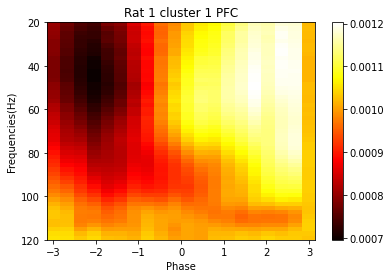

(1584, 102, 102)
(1584, 51)
(1584, 51)
1.9419607408861013e-05


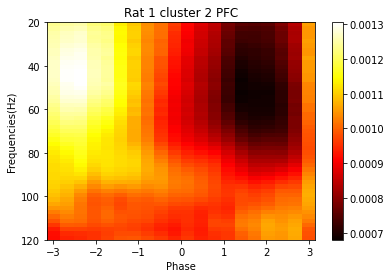

(1200, 102, 102)
(1200, 51)
(1200, 51)
1.38698530822331e-05


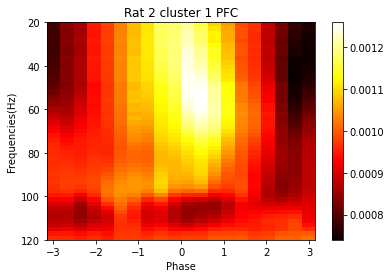

(876, 102, 102)
(876, 51)
(876, 51)
1.511095313688495e-05


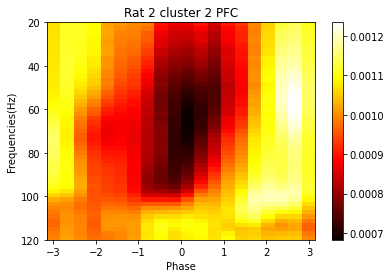

(424, 102, 102)
(424, 51)
(424, 51)
1.6816436325899137e-05


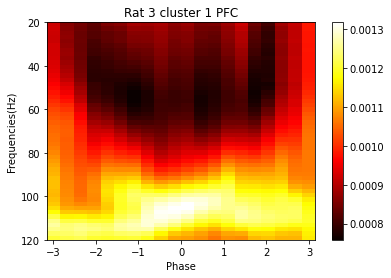

(444, 102, 102)
(444, 51)
(444, 51)
1.6205114080942936e-05


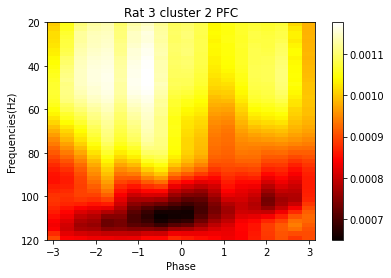

(2288, 102, 102)
(2288, 51)
(2288, 51)
1.6470126580111494e-05


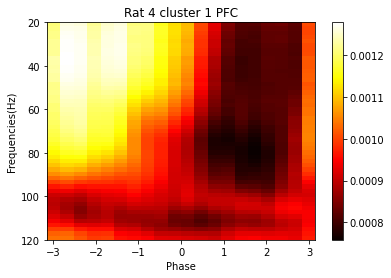

(1856, 102, 102)
(1856, 51)
(1856, 51)
1.4466035628558438e-05


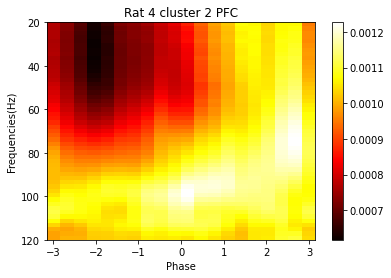

(2050, 102, 102)
(2050, 51)
(2050, 51)
1.835466735179689e-05


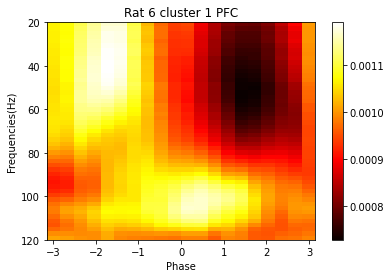

(1970, 102, 102)
(1970, 51)
(1970, 51)
1.57518577367196e-05


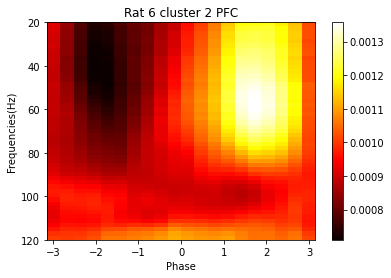

(1962, 102, 102)
(1962, 51)
(1962, 51)
1.676667822830058e-05


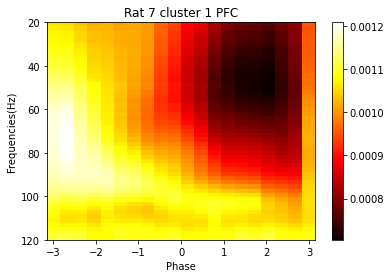

(2028, 102, 102)
(2028, 51)
(2028, 51)
1.3311089031529812e-05


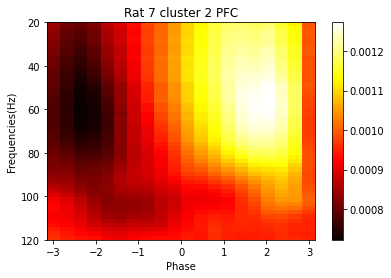

(2232, 102, 102)
(2232, 51)
(2232, 51)
1.7407768071082065e-05


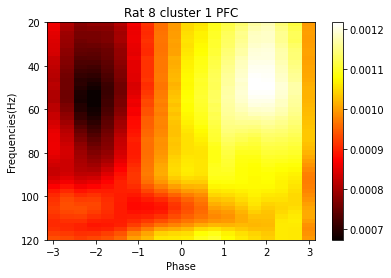

(2088, 102, 102)
(2088, 51)
(2088, 51)
1.949208961772308e-05


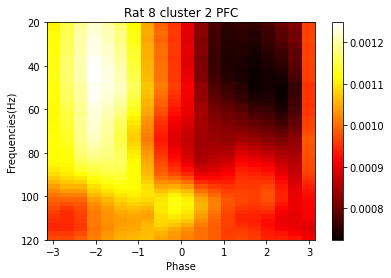

(1400, 102, 102)
(1400, 51)
(1400, 51)
1.9469163921293446e-05


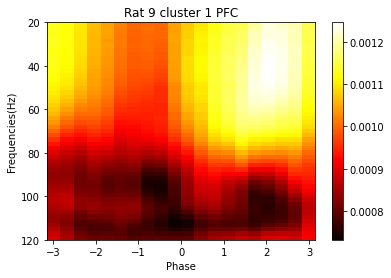

(1544, 102, 102)
(1544, 51)
(1544, 51)
1.8437746235554025e-05


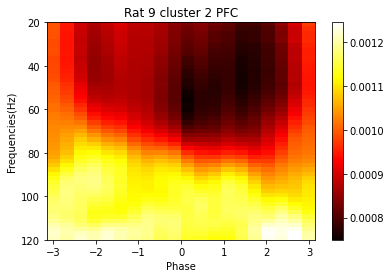

(2952, 102, 102)
(2952, 51)
(2952, 51)
2.0991092071634672e-05


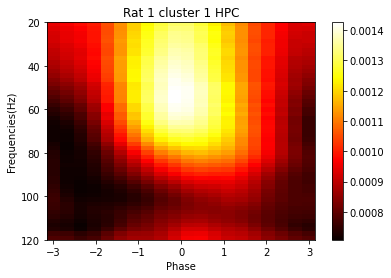

(2440, 102, 102)
(2440, 51)
(2440, 51)
2.060040447622481e-05


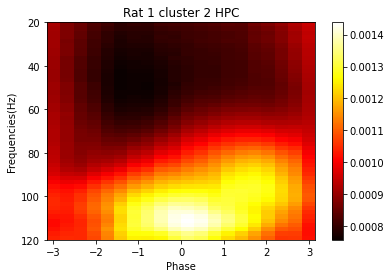

(3420, 102, 102)
(3420, 51)
(3420, 51)
1.667694589904071e-05


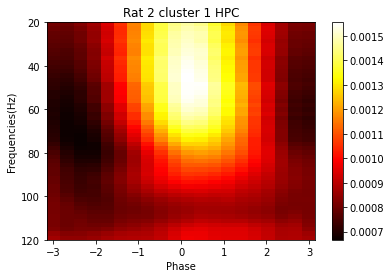

(2172, 102, 102)
(2172, 51)
(2172, 51)
1.91728861608519e-05


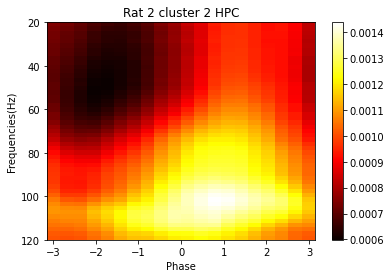

(1188, 102, 102)
(1188, 51)
(1188, 51)
2.2095818070071927e-05


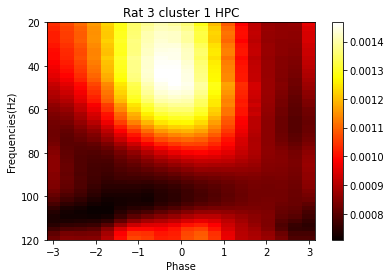

(1212, 102, 102)
(1212, 51)
(1212, 51)
1.9690895330141e-05


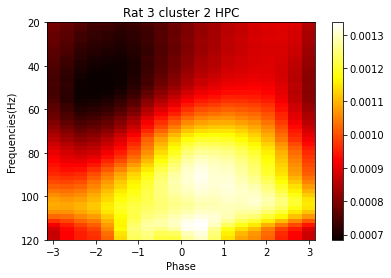

(3968, 102, 102)
(3968, 51)
(3968, 51)
1.603169834752637e-05


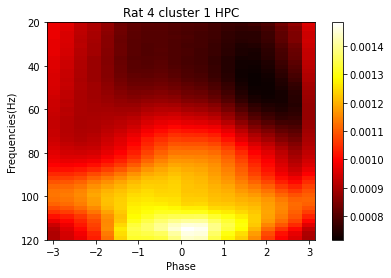

(4464, 102, 102)
(4464, 51)
(4464, 51)
1.8841906637440394e-05


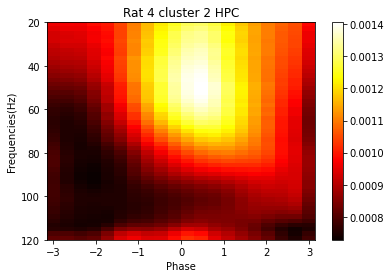

(4460, 102, 102)
(4460, 51)
(4460, 51)
1.5105841468239152e-05


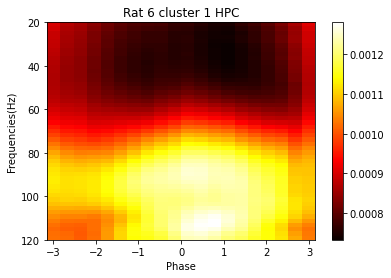

(4720, 102, 102)
(4720, 51)
(4720, 51)
1.592889529063729e-05


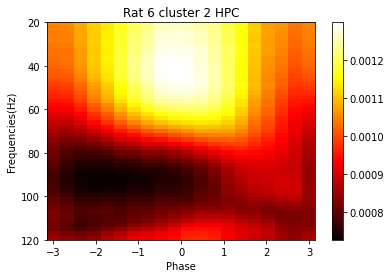

(3528, 102, 102)
(3528, 51)
(3528, 51)
2.044532423856841e-05


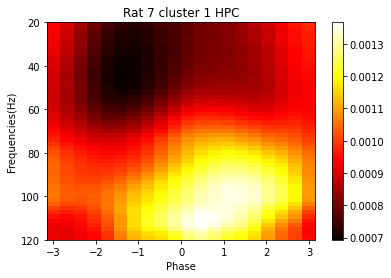

(3300, 102, 102)
(3300, 51)
(3300, 51)
1.9224625426858395e-05


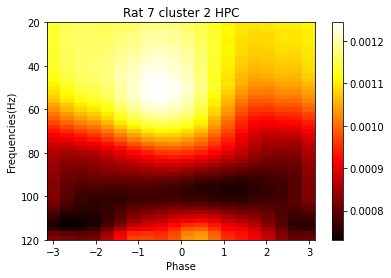

(3552, 102, 102)
(3552, 51)
(3552, 51)
1.2427465556083368e-05


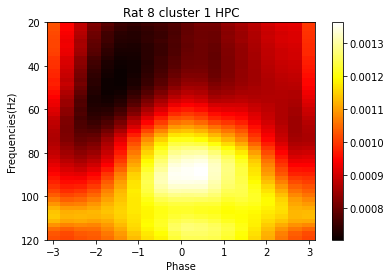

(3816, 102, 102)
(3816, 51)
(3816, 51)
1.4952264178612607e-05


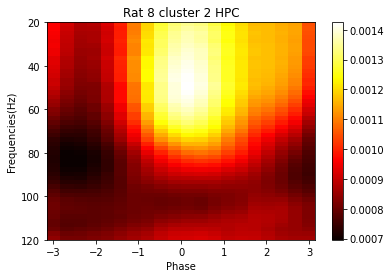

(3568, 102, 102)
(3568, 51)
(3568, 51)
2.3886467222198926e-05


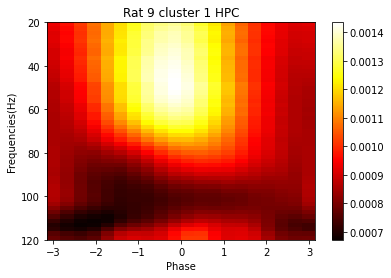

(3352, 102, 102)
(3352, 51)
(3352, 51)
2.3921006487967163e-05


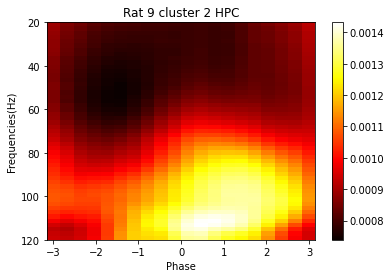

In [150]:
gamma_clusters_pfc,pfc_cluster_ex, pfc_cluster_in, mpfc_cluster_ex, mpfc_cluster_in,lr_pfc=gamma_sort(pls_pfc,  'PFC')
gamma_clusters_hpc,hpc_cluster_ex,hpc_cluster_in, mhpc_cluster_ex, mhpc_cluster_in,lr_hpc=gamma_sort(pls_hpc,  'HPC')

In [135]:
df_clusters =  df(columns =['Rat', 'Cluster_Number','Mutation/Control', 'Condition','PFC_Clusters', 'HPC_Clusters', 'PFC_Gamma_Clusters', 'HPC_Gamma_Clusters'])
df_clusters['PFC_Clusters']= df_clusters['PFC_Clusters'].astype(object)
df_clusters['HPC_Clusters']= df_clusters['HPC_Clusters'].astype(object)
df_clusters['PFC_Gamma_Clusters']= df_clusters['PFC_Gamma_Clusters'].astype(object)
df_clusters['HPC_Gamma_Clusters']= df_clusters['HPC_Gamma_Clusters'].astype(object)
mclist=['Control', 'Control','Mutation', 'Mutation',  'Control', 'Mutation', 'Mutation','Control']
for i in range(0,8):
    j=i+1
    if j >= 5:
        j+=1
    for num in range(len(gamma_clusters_hpc[i])):
        hpc_extra = hpc_cluster_ex[i][num]
        hpc_intra =hpc_cluster_in[i][num]
        pfc_extra =pfc_cluster_ex[i][num]
        pfc_intra = pfc_cluster_in[i][num]
        m_hpc_extra = mhpc_cluster_ex[i][num]
        m_hpc_intra =mhpc_cluster_in[i][num]
        m_pfc_extra =mpfc_cluster_ex[i][num]
        m_pfc_intra = mpfc_cluster_in[i][num]
        lr_hpc_extra = lr_hpc[i][num]
        lr_pfc_extra =lr_pfc[i][num]
        df_clusters=df_clusters.append({'Rat':j,'Cluster_Number':num+1,'Mutation/Control': mclist[i],'Condition':'HomeCage', 'PearsonDistance_PFC_Intra_Cluster': pfc_intra,\
                                        'PearsonDistance_PFC_Inter_cluster':pfc_extra,'PearsonDistance_HPC_Intra_Cluster': hpc_intra, \
                                        'PearsonDistance_HPC_Inter_cluster':hpc_extra,'MahalanobisDistance_PFC_Intra_Cluster': m_pfc_intra,\
                                        'MahalanobisDistance_PFC_Inter_cluster':m_pfc_extra,'MahalanobisDistance_HPC_Intra_Cluster': m_hpc_intra, \
                                        'MahalanobisDistance_HPC_Inter_cluster':m_hpc_extra,'LRatio_PFC':lr_pfc_extra,'LRatio_HPC':lr_hpc_extra,'PFC_Clusters':pfc_clusters[i][num], 'HPC_Clusters': hpc_clusters[i][num], \
                                        'PFC_Gamma_Clusters':gamma_clusters_pfc[i][num], 'HPC_Gamma_Clusters':gamma_clusters_hpc[i][num]}, ignore_index=True)

/tmp/ipykernel_3516/3272280813.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_clusters=df_clusters.append({'Rat':j,'Cluster_Number':num+1,'Mutation/Control': mclist[i],'Condition':'HomeCage', 'PearsonDistance_PFC_Intra_Cluster': pfc_intra,\
/tmp/ipykernel_3516/3272280813.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_clusters=df_clusters.append({'Rat':j,'Cluster_Number':num+1,'Mutation/Control': mclist[i],'Condition':'HomeCage', 'PearsonDistance_PFC_Intra_Cluster': pfc_intra,\
/tmp/ipykernel_3516/3272280813.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_clusters=df_clusters.append({'Rat':j,'Cluster_Number':num+1,'Mutation/Control': mclist[i],'Condition':'HomeCage', 'PearsonDistance_PFC_Intra_Clust

In [16]:
df_clusters.to_csv('Clustersk_120_2_intramean.csv')

In [136]:
df_clusters

,Rat,Cluster_Number,Mutation/Control,Condition,PFC_Clusters,HPC_Clusters,PFC_Gamma_Clusters,HPC_Gamma_Clusters,LRatio_HPC,LRatio_PFC,MahalanobisDistance_HPC_Inter_cluster,MahalanobisDistance_HPC_Intra_Cluster,MahalanobisDistance_PFC_Inter_cluster,MahalanobisDistance_PFC_Intra_Cluster,PearsonDistance_HPC_Inter_cluster,PearsonDistance_HPC_Intra_Cluster,PearsonDistance_PFC_Inter_cluster,PearsonDistance_PFC_Intra_Cluster
0,1,1,Control,HomeCage,"[1, 2, 5, 6, 7, 8, 9, 10, 15, 16, 18, 21, 23, ...","[0, 1, 5, 7, 8, 11, 15, 16, 17, 20, 22, 24, 25...","[[0.0008040637326836728, 0.0007736175906342522...","[[0.0009468124669014229, 0.0009632483693030169...",0.000021,0.000014,6.319061,6.319916,6.328306,6.300775,0.803743,0.532978,0.849158,0.640890
1,1,2,Control,HomeCage,"[0, 3, 4, 11, 12, 13, 14, 17, 19, 20, 22, 25, ...","[2, 3, 4, 6, 9, 10, 12, 13, 14, 18, 19, 21, 23...","[[0.0012346264447259466, 0.0012451309469388918...","[[0.0009174663109955194, 0.0008764051233300212...",0.000021,0.000019,6.318961,6.288063,6.315808,6.311617,0.653235,0.795195,0.850695,0.647265
2,2,1,Control,HomeCage,"[1, 2, 3, 4, 5, 6, 7, 8, 11, 14, 16, 17, 18, 1...","[2, 3, 5, 6, 7, 8, 11, 13, 15, 19, 20, 21, 22,...","[[0.0007872008231175002, 0.0008429480345506195...","[[0.000808690915515726, 0.0008017810154682483,...",0.000017,0.000014,6.320465,6.306210,6.311504,6.286651,0.551961,0.477197,0.846651,0.696056
3,2,2,Control,HomeCage,"[0, 9, 10, 12, 13, 15, 20, 21, 24, 25, 26, 27,...","[0, 1, 4, 9, 10, 12, 14, 16, 17, 18, 24, 25, 3...","[[0.0010702494948943994, 0.0011124771323647099...","[[0.0007490526847158671, 0.0007325180362221895...",0.000019,0.000015,6.316731,6.286154,6.303152,6.276697,0.554784,0.550022,0.862110,0.677346
4,3,1,Mutation,HomeCage,"[0, 2, 10, 13, 14, 15, 17, 18, 19, 20, 21, 23,...","[0, 1, 3, 5, 7, 8, 10, 11, 12, 14, 18, 19, 20,...","[[0.0009218275109462331, 0.000862197288939856,...","[[0.0010377017002437439, 0.001067711734058149,...",0.000022,0.000017,6.302839,6.294816,6.305178,6.280178,0.675012,0.709945,0.819668,0.822589
5,3,2,Mutation,HomeCage,"[1, 3, 4, 5, 6, 7, 8, 9, 11, 12, 16, 22, 26, 2...","[2, 4, 6, 9, 13, 15, 16, 17, 24, 25, 27, 28, 3...","[[0.0010037722783352771, 0.001055245086038285,...","[[0.0007925149735946784, 0.0007768520882112959...",0.000020,0.000016,6.302621,6.279797,6.310925,6.282453,0.743830,0.625509,0.857096,0.794554
6,4,1,Mutation,HomeCage,"[0, 1, 4, 5, 7, 10, 11, 13, 15, 18, 19, 20, 21...","[0, 7, 8, 10, 14, 18, 19, 20, 21, 24, 27, 30, ...","[[0.001207504094776681, 0.0012631331568175802,...","[[0.000977076411938896, 0.0009669610668989479,...",0.000016,0.000016,6.309925,6.284020,6.317520,6.305721,0.704613,0.794155,0.827494,0.631318
7,4,2,Mutation,HomeCage,"[2, 3, 6, 8, 9, 12, 14, 16, 17, 22, 23, 28, 29...","[1, 2, 3, 4, 5, 6, 9, 11, 12, 13, 15, 16, 17, ...","[[0.0007697612809109288, 0.0007316942392053515...","[[0.0009590305228619066, 0.0009690180641671488...",0.000019,0.000014,6.304749,6.306202,6.322759,6.281179,0.810280,0.606435,0.811801,0.647391
8,6,1,Control,HomeCage,"[0, 1, 2, 4, 5, 6, 7, 8, 11, 12, 20, 21, 25, 2...","[0, 1, 2, 4, 6, 8, 9, 10, 11, 12, 13, 15, 17, ...","[[0.0010662306627367611, 0.0010770017876534255...","[[0.0009024707690427469, 0.0008734095961473312...",0.000015,0.000018,6.331306,6.314899,6.317308,6.300382,0.768113,0.863506,0.841341,0.725216
9,6,2,Control,HomeCage,"[3, 9, 10, 13, 14, 15, 16, 17, 18, 19, 22, 23,...","[3, 5, 7, 14, 16, 20, 25, 28, 29, 32, 33, 39, ...","[[0.0009160830884562038, 0.0008456691948301849...","[[0.00104965283279743, 0.001053858798927898, 0...",0.000016,0.000016,6.334400,6.328351,6.321591,6.305424,0.863825,0.741186,0.868224,0.658928
